## Analysis of historical data of IPC levels
For this analysis we use two sources of IPC levels, those produced by [FewsNet](https://fews.net) and those producted by [Global IPC](http://www.ipcinfo.org).   
FewsNet has produced these analyses since 2009. Global IPC is a more recent initiative where the timing and coverage of the analysis depends on the country. For Ethiopia currently (Oct 2020) two analyses have been done, one in 2019 and one in 2020. 

In [2]:
%load_ext autoreload
%autoreload 2
# %load_ext jupyter_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from datetime import timedelta
import matplotlib.dates as dates
from sklearn.metrics import accuracy_score
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.food_insecurity.config import ConfigFI

In [4]:
iso3="eth"
admin_level=1
#suffix of filenames
suffix=""
config=ConfigFI()
parameters = config.parameters(iso3)

public_data_dir = os.path.join(config.DATA_DIR, config.PUBLIC_DIR)
country_data_raw_dir = os.path.join(public_data_dir,config.RAW_DIR,iso3)
country_data_processed_dir = os.path.join(public_data_dir,config.PROCESSED_DIR,iso3)
adm1_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin1_shp"])

fnwp_dir = os.path.join(country_data_processed_dir, config.FEWSWORLDPOP_PROCESSED_DIR)
fnwp_path = os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(iso3=iso3,admin_level=admin_level,suffix=suffix))
fnwp_adm0_path=os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(iso3=iso3,admin_level=0,suffix=suffix))
fnwp_adm2_path=os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(iso3=iso3,admin_level=2,suffix=suffix))
globalipc_dir=os.path.join(country_data_processed_dir, config.GLOBALIPC_PROCESSED_DIR)
globalipc_path=os.path.join(globalipc_dir,f"{iso3}_globalipc_admin{admin_level}{suffix}.csv")

In [5]:
fnocha_dir = os.path.join(country_data_processed_dir, config.FEWSADMPOP_PROCESSED_DIR)
# fnwp_path = os.path.join(fnwp_dir,config.FEWSWORLDPOP_PROCESSED_FILENAME.format(iso3=iso3,admin_level=admin_level,suffix=suffix))
fnocha_path = os.path.join(fnocha_dir,f"{iso3}_fewsnet_admin{admin_level}.csv")
fnocha_adm2_path = os.path.join(fnocha_dir,f"{iso3}_fewsnet_admin2.csv")

#### Load FewsNet data

In [6]:
df_fadm=pd.read_csv(fnwp_path,parse_dates=["date"])

In [7]:
#these are updates without new CS data, remove for cleanness
df_fadm=df_fadm[~df_fadm.date.isin(["2020-08-01","2020-09-01","2021-01-01"])]

In [8]:
df_fnat=pd.read_csv(fnwp_adm0_path,parse_dates=["date"])

In [9]:
#these are updates without new CS data, remove for cleanness
df_fnat=df_fnat[~df_fnat.date.isin(["2020-08-01","2020-09-01"])]

##### Check for missing data

In [10]:
print("Number of date-admin1 combinations with no IPC CS data:", len(df_fadm[df_fadm.pop_CS==0]))

Number of date-admin1 combinations with no IPC CS data: 0


In [11]:
print("Percentage of missing data:",len(df_fadm[df_fadm.pop_CS==0])/len(df_fadm)*100)

Percentage of missing data: 0.0


#### Load Global IPC data

In [12]:
df_gadm=pd.read_csv(globalipc_path)

In [13]:
df_gadm["date"]=pd.to_datetime(df_gadm["date"])
df_gadm["year"]=df_gadm["date"].dt.year
df_gadm["month"]=df_gadm["date"].dt.month

In [14]:
adm1c="ADMIN1"

In [15]:
#group to country
df_gnat=pd.read_csv(os.path.join(globalipc_dir,f"{iso3}_globalipc_admin0{suffix}.csv"),parse_dates=["date"])

In [16]:
df_gnat.loc[df_gnat["date"]=="2019-09-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2019-10-01","pop_total_CS"].values
df_gnat.loc[df_gnat["date"]=="2020-08-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2020-10-01","pop_total_CS"].values
df_gnat.loc[df_gnat["date"]=="2020-10-01","pop_total_CS"]=df_fnat.loc[df_fnat["date"]=="2020-10-01","pop_total_CS"].values

### Analysis of historical IPC values
To get a better understanding of the country's typical values and history, both on national and admin1 level

In [17]:
def plot_ipclevels(df,adm1c="ADMIN1",pop_col="pop_total_CS",status="CS",perc=False,figsize=(30,30),width=75,title=None):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
#     width = 75
    count = 1
    fig, ax = plt.subplots(figsize=figsize)
    if perc:
        perc_str="perc_"
    else:
        perc_str=""
    if f"{perc_str}{status}_12" not in df.columns:
        df[f"{perc_str}{status}_12"]=df[f"{perc_str}{status}_1"]+df[f"{perc_str}{status}_2"]
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        df_c=df.copy()
        data = df_c.loc[df_c[adm1c]==region,:]
        
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_5'], width=width, color=color_map[5],label="IPC 5")
        p4 = plt.bar(data['date'], data[f'{perc_str}{status}_4'], width=width, color=color_map[4],label="IPC 4")
        p3 = plt.bar(data['date'], data[f'{perc_str}{status}_3'], width=width, color=color_map[3], bottom=(data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 3")
        p2 = plt.bar(data['date'], data[f'{perc_str}{status}_12'], width=width, color=color_map[1], bottom=(data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="IPC 1 and 2")
        if not perc:
            data["pop_miss"]=data[pop_col]-(data[f"pop_{status}"].replace(np.nan,0))
            p1 = plt.bar(data['date'], data['pop_miss'], width=width, color=color_map[99], bottom=(data[f"{perc_str}{status}_12"]+data[f'{perc_str}{status}_3']+data[f'{perc_str}{status}_4']+data[f'{perc_str}{status}_5']).to_numpy(),label="Missing data")
        if title is not None:
            plt.title(title)
        else:
            plt.title(f"{region} {perc_str}{status}")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        if not perc:
            ax.set_ylabel("Population")
        else:
            ax.set_ylabel("Percentage of population")
        ax.xaxis.set_minor_locator(dates.MonthLocator())
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
        ax.xaxis.set_major_locator(dates.YearLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%Y'))
        plt.tight_layout()
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    return fig

#### FewsNet

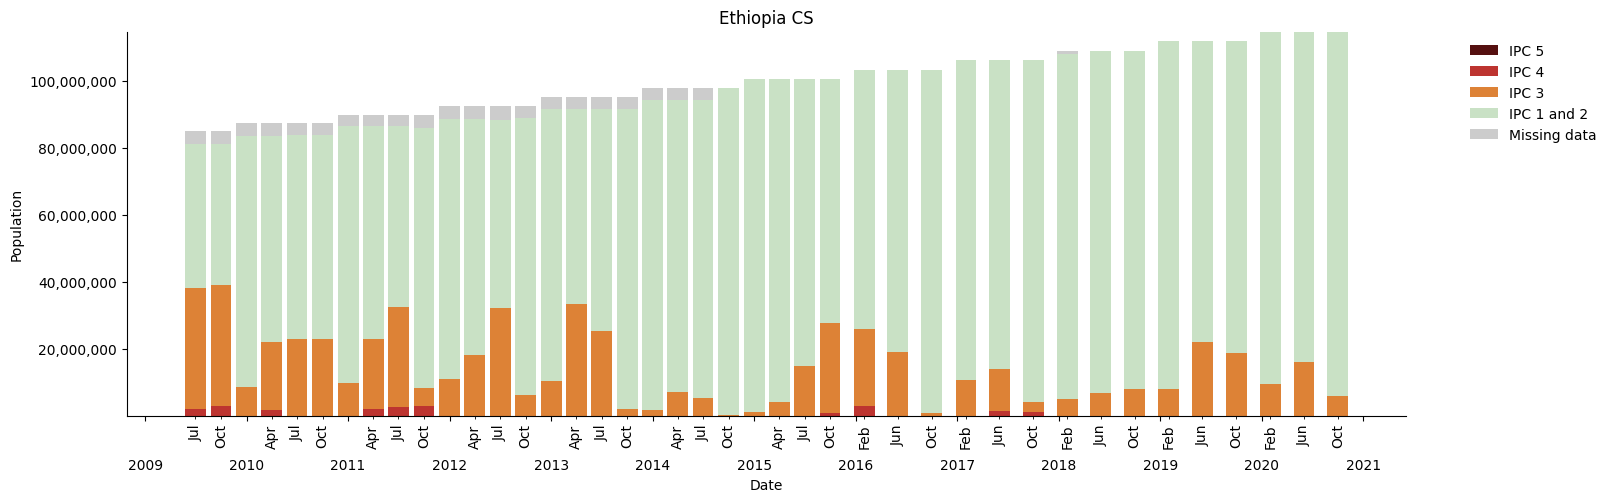

In [18]:
plot_ipclevels(df_fnat,adm1c="ADMIN0")

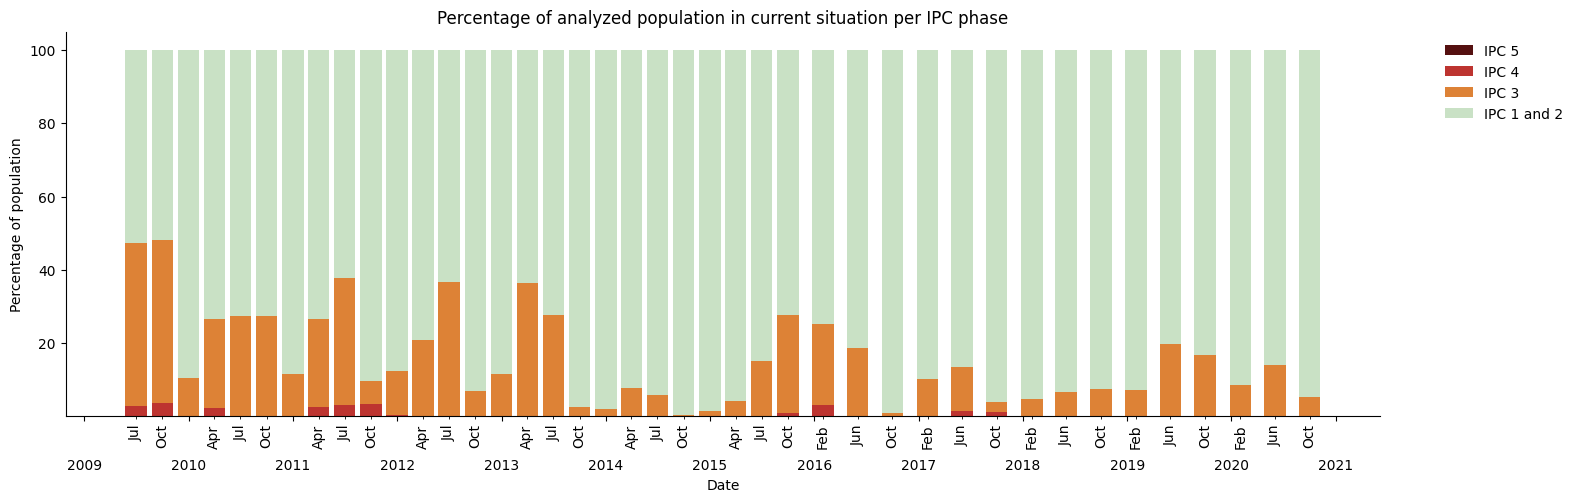

In [19]:
plot_ipclevels(df_fnat,adm1c="ADMIN0",status="CS",perc=True,title="Percentage of analyzed population in current situation per IPC phase")

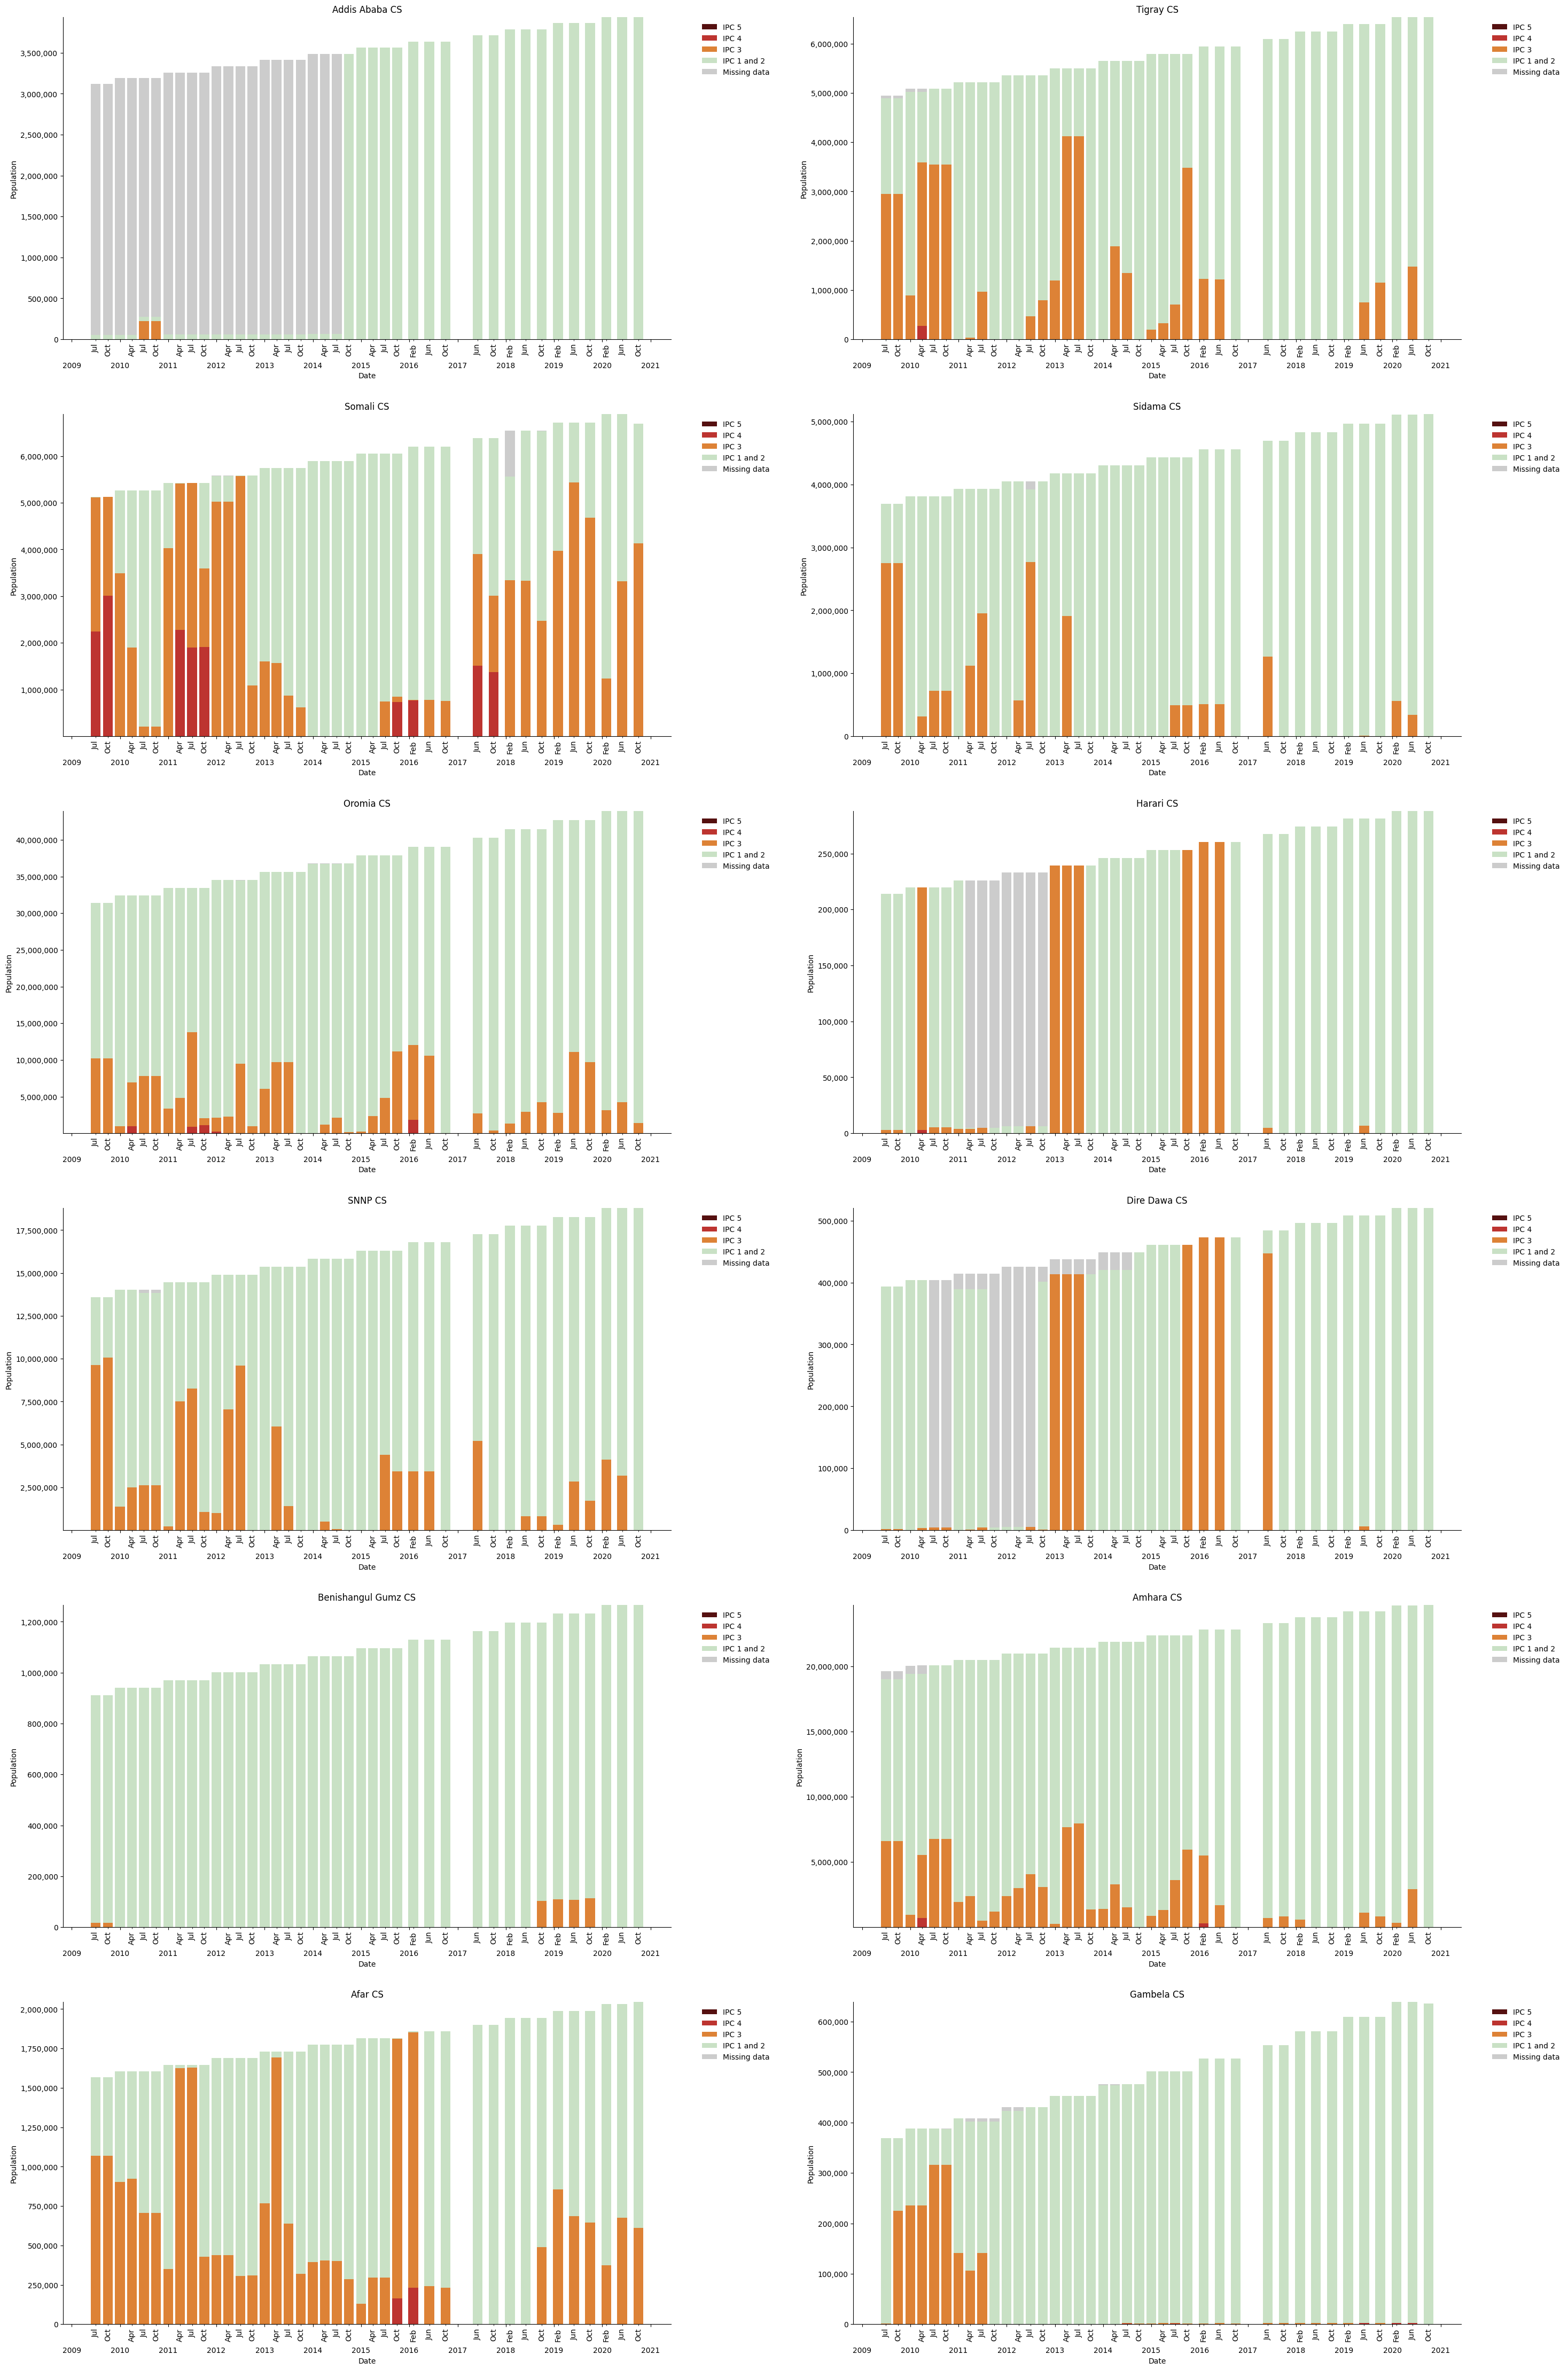

In [20]:
plot_ipclevels(df_fadm,figsize=(30,45))

#### Global IPC

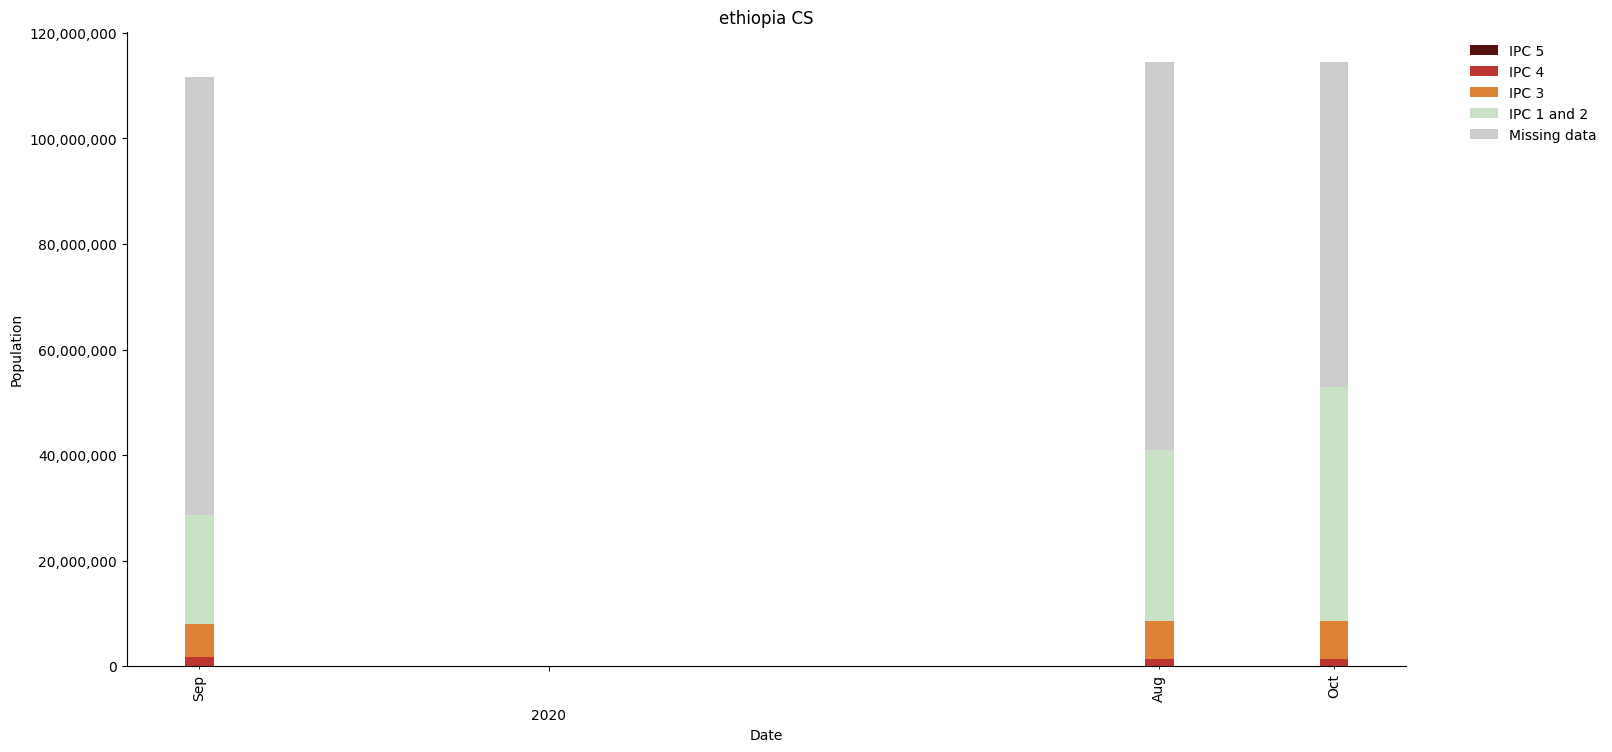

In [21]:
plot_ipclevels(df_gnat,adm1c="ADMIN0",pop_col="pop_total_CS",figsize=(30,45),width=10)

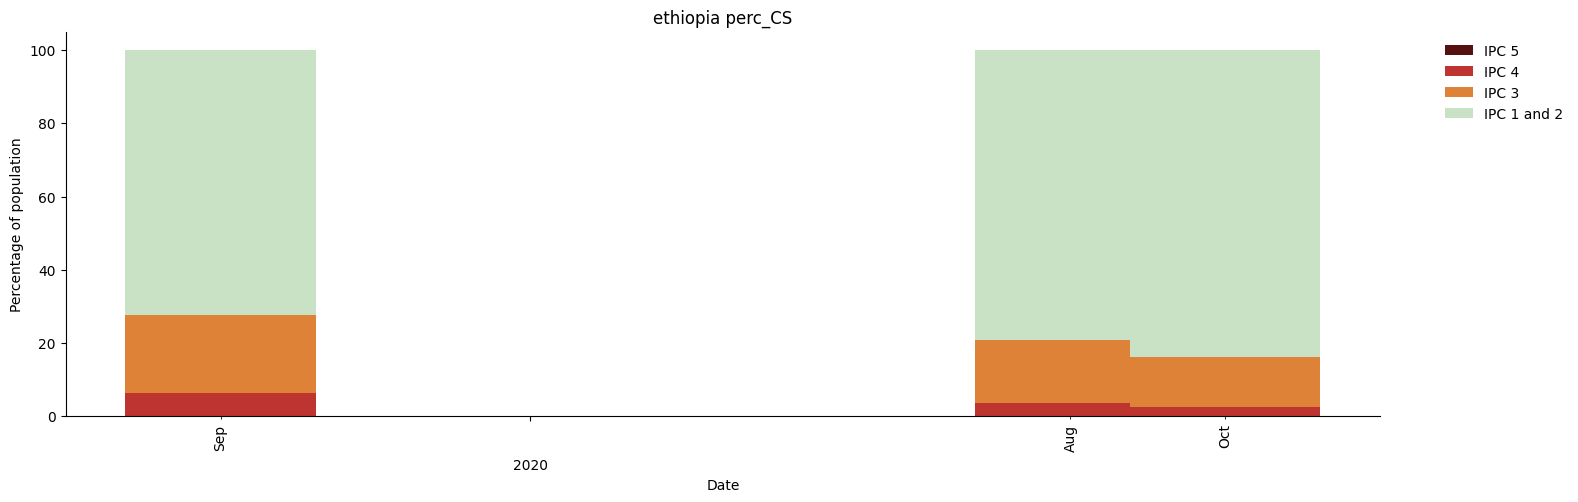

In [22]:
plot_ipclevels(df_gnat,adm1c="ADMIN0",status="CS",perc=True)

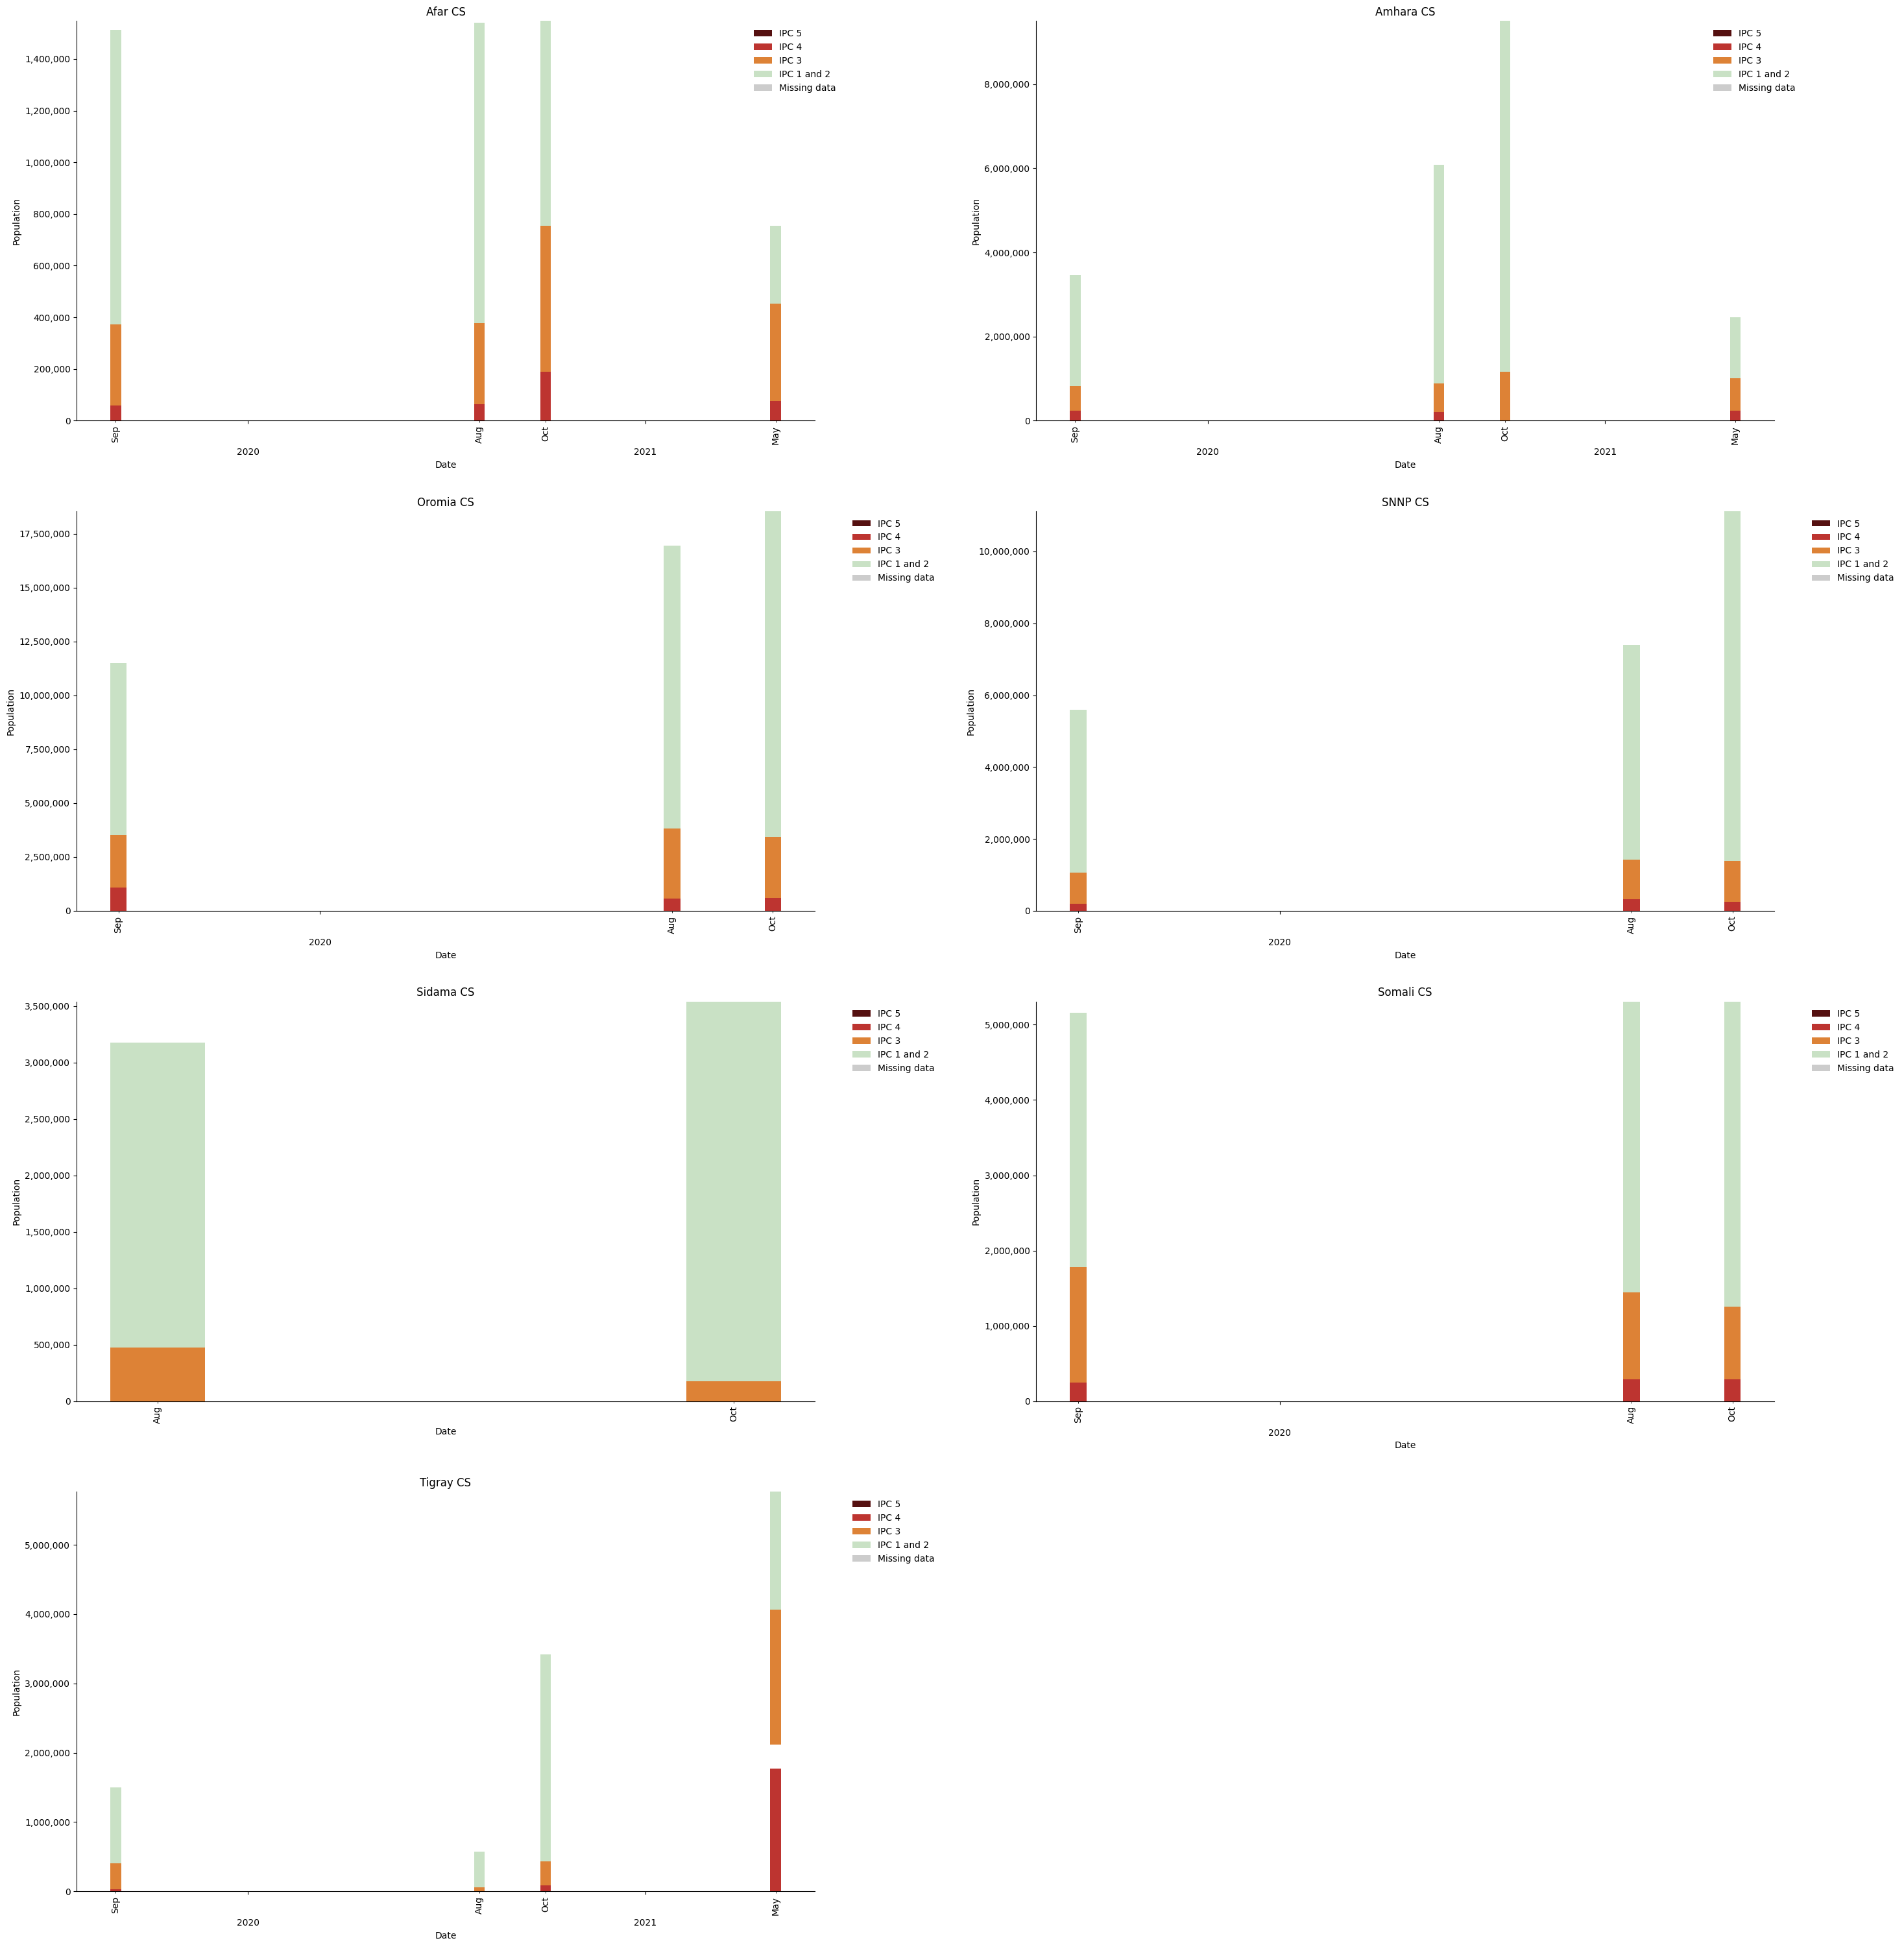

In [23]:
plot_ipclevels(df_gadm,adm1c=adm1c,pop_col="pop_CS",figsize=(30,45),width=10)

In [24]:
def plot_aff_dates(df_d,col,gdf,
#                    shape_path="Data/ET_Admin1_OCHA_2019/eth_admbnda_adm1_csa_bofed_20190827.shp",
                   df_d_adm_col="ADMIN1",
                   gdf_adm_col="ADM1_EN",
                   title=None):
    """Plot a map with the values of col per admin1 for all dates included in df_d"""
    num_dates=len(df_d.date.unique())
    colp_num=2
    rows=num_dates // colp_num
    rows+=num_dates % colp_num
    position = range(1, num_dates + 1)

#     gdf = gpd.read_file(shape_path)
    df_geo=gdf[[gdf_adm_col,"geometry"]].merge(df_d,left_on=gdf_adm_col,right_on=df_d_adm_col,how="left")
    
    colors = len(df_geo[col].unique())
    cmap = 'Blues'
    figsize = (16, 10)
    scheme = "natural_breaks"#'equalinterval'
    fig = plt.figure(1,figsize=(16,6*rows))
    
    for i,c in enumerate(df_d.date.unique()):
        ax = fig.add_subplot(rows,colp_num,position[i])
        df_date=df_geo[df_geo.date==c]
        if df_date[col].isnull().values.all():
            print(f"No not-NaN values for {c}")
        elif df_date[col].isnull().values.any():
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme,missing_kwds={"color": "lightgrey", "edgecolor": "red",
   "hatch": "///",
    "label": "Missing values"})
        else:
            df_geo[df_geo.date==c].plot(col, ax=ax,cmap=cmap, figsize=figsize, k = colors,  legend=True,scheme=scheme)
        gdf.boundary.plot(linewidth=0.2,ax=ax)

        ax.axis("off")
        
        plt.title(pd.DatetimeIndex([c])[0].to_period('M'))
        if not df_date[col].isnull().values.all():
            leg = ax.get_legend()

            for lbl in leg.get_texts():
                label_text = lbl.get_text()
                upper = label_text.split(",")[-1].rstrip(']')

                try:
                    new_text = f'{float(upper):,.2f}'
                except:
                    new_text=upper
                lbl.set_text(new_text)

    if title:
        fig.suptitle(title,fontsize=14)
    fig.tight_layout()
    return fig

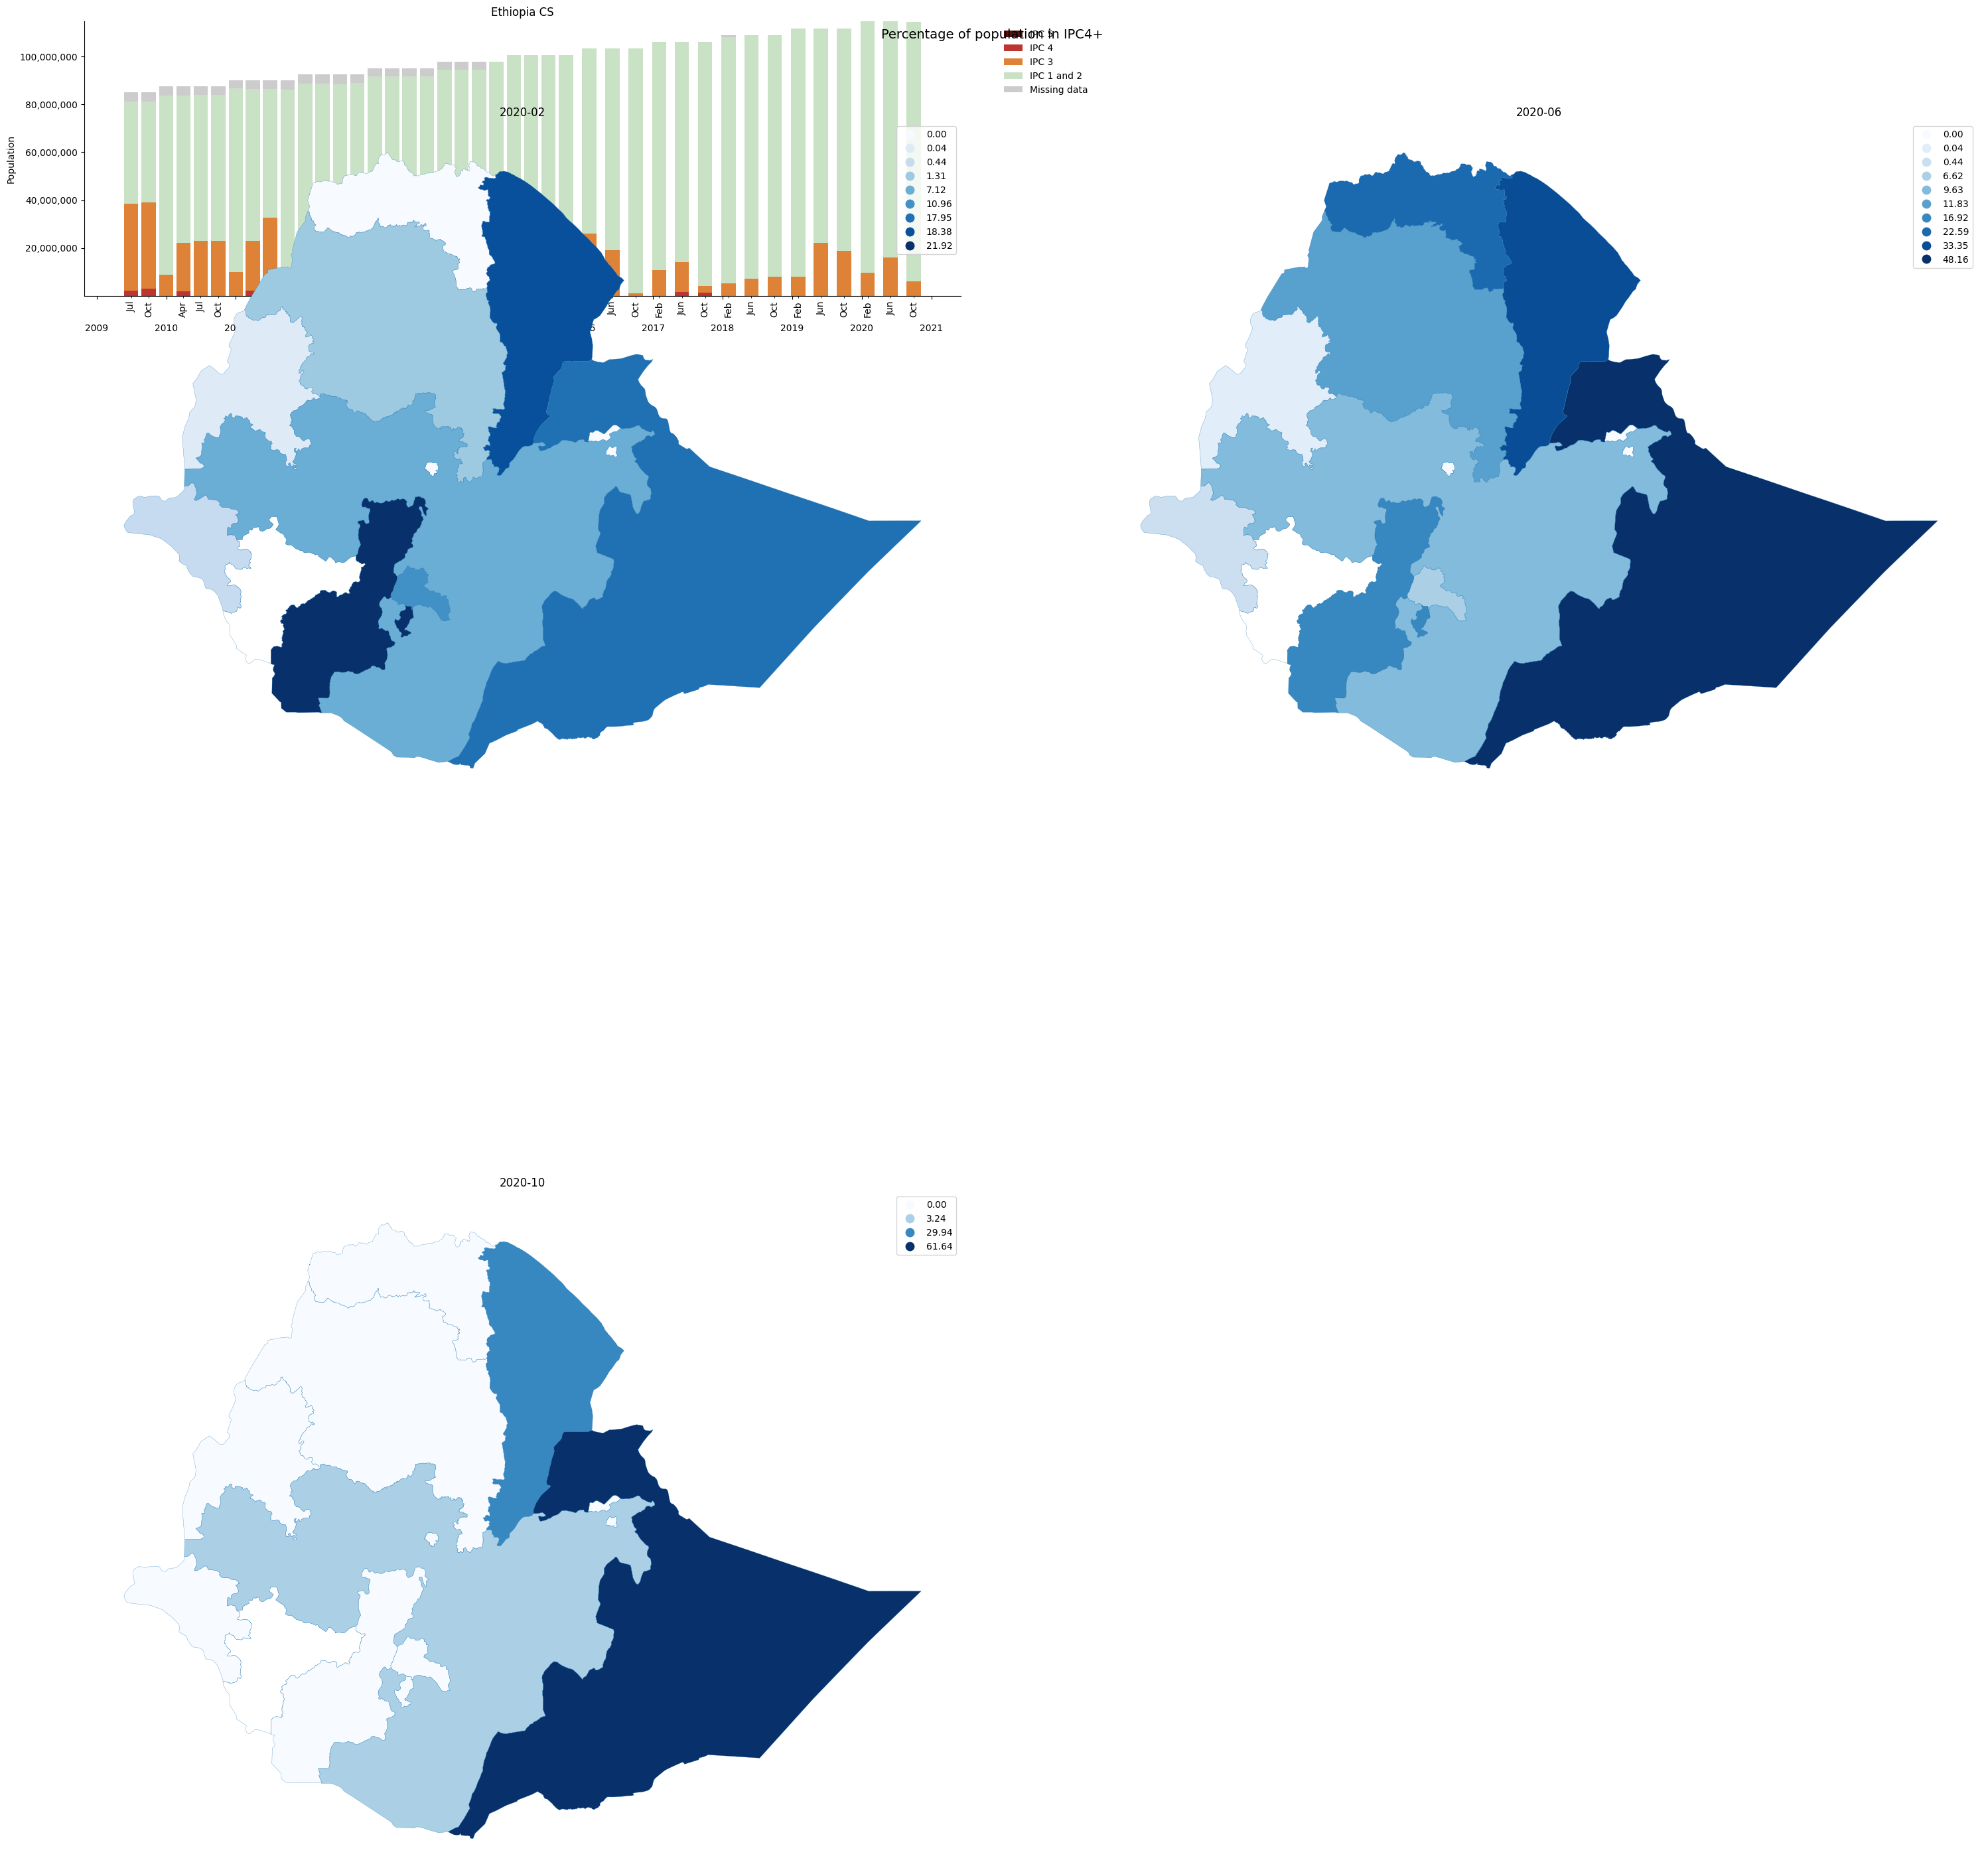

In [25]:
gdf_adm1=gpd.read_file(adm1_bound_path)
plot_aff_dates(df_fadm[df_fadm.date.dt.year==2020],"perc_CS_3p",gdf=gdf_adm1,title="Percentage of population in IPC4+")

### Compare Global IPC and FewsNet

In [26]:
df_fnat["Source"]="FewsNet"
df_gnat["Source"]="Global"

In [27]:
#manually select the closes dates of Global IPC and FewsNet..
list(df_gnat.date.dt.date.unique())

[datetime.date(2019, 9, 1),
 datetime.date(2020, 8, 1),
 datetime.date(2020, 10, 1)]

In [28]:
df_fnat.date.dt.date.unique()

array([datetime.date(2009, 7, 1), datetime.date(2009, 10, 1),
       datetime.date(2010, 1, 1), datetime.date(2010, 4, 1),
       datetime.date(2010, 7, 1), datetime.date(2010, 10, 1),
       datetime.date(2011, 1, 1), datetime.date(2011, 4, 1),
       datetime.date(2011, 7, 1), datetime.date(2011, 10, 1),
       datetime.date(2012, 1, 1), datetime.date(2012, 4, 1),
       datetime.date(2012, 7, 1), datetime.date(2012, 10, 1),
       datetime.date(2013, 1, 1), datetime.date(2013, 4, 1),
       datetime.date(2013, 7, 1), datetime.date(2013, 10, 1),
       datetime.date(2014, 1, 1), datetime.date(2014, 4, 1),
       datetime.date(2014, 7, 1), datetime.date(2014, 10, 1),
       datetime.date(2015, 1, 1), datetime.date(2015, 4, 1),
       datetime.date(2015, 7, 1), datetime.date(2015, 10, 1),
       datetime.date(2016, 2, 1), datetime.date(2016, 6, 1),
       datetime.date(2016, 10, 1), datetime.date(2017, 2, 1),
       datetime.date(2017, 6, 1), datetime.date(2017, 10, 1),
       datetime

In [29]:
df_gnatd=df_gnat[df_gnat.date.isin(["2019-9","2020-08"])]

In [30]:
df_fnatd=df_fnat[df_fnat.date.isin(["2019-10","2020-10"])]

In [31]:
df_fnatd[["period_ML1","period_ML2"]]

period_ML1      period_ML2
37  Oct - Jan 2020  Feb - May 2020
42  Oct - Jan 2021  Feb - May 2021

In [32]:
df_fnatd["perc_ML1_2m"]

37    93.175128
42    91.594779
Name: perc_ML1_2m, dtype: float64

In [33]:
df_comb=pd.concat([df_gnatd,df_fnatd])

In [34]:
df_comb

date    ADMIN0          CS_1          CS_2          CS_3  \
0  2019-09-01  ethiopia  1.072652e+07  1.003359e+07  6.110425e+06   
1  2020-08-01  ethiopia  1.951484e+07  1.300769e+07  7.064142e+06   
37 2019-10-01  Ethiopia  6.285802e+07  3.003877e+07  1.883879e+07   
42 2020-10-01  Ethiopia  8.186663e+07  2.646539e+07  6.164422e+06   

            CS_4  CS_5         ML1_1         ML1_2         ML1_3  ...  \
0   1.856568e+06   0.0  1.149247e+07  1.054484e+07  5.356000e+06  ...   
1   1.441541e+06   0.0  2.191713e+07  1.244078e+07  5.856056e+06  ...   
37  8.062720e+02   0.0  7.890035e+07  2.520994e+07  7.625042e+06  ...   
42  0.000000e+00   0.0  7.936297e+07  2.550979e+07  9.623679e+06  ...   

         CS_4p         CS_2m        ML1_3p      ML1_4p        ML1_2m  \
0          NaN           NaN           NaN         NaN           NaN   
1          NaN           NaN           NaN         NaN           NaN   
37  806.271973  9.289679e+07  7.625848e+06  806.272034  1.041103e+08   
42    0.000000  1.083320e+08  9.623679e+06    0.000000  1.048728e+08   

          ML2_3p      ML2_4p        ML2_2m      period_ML1      period_ML2  
0            NaN         NaN           NaN             NaN             NaN  
1            NaN         NaN           NaN             NaN             NaN  
37  2.020490e+07  938.026489  9.153164e+07  Oct - Jan 2020  Feb - May 2020  
42  2.581378e+07    0.000000  8.868266e+07  Oct - Jan 2021  Feb - May 2021  

[4 rows x 66 columns]

In [35]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])

In [36]:
df_combm["year"]=df_combm.date.dt.year

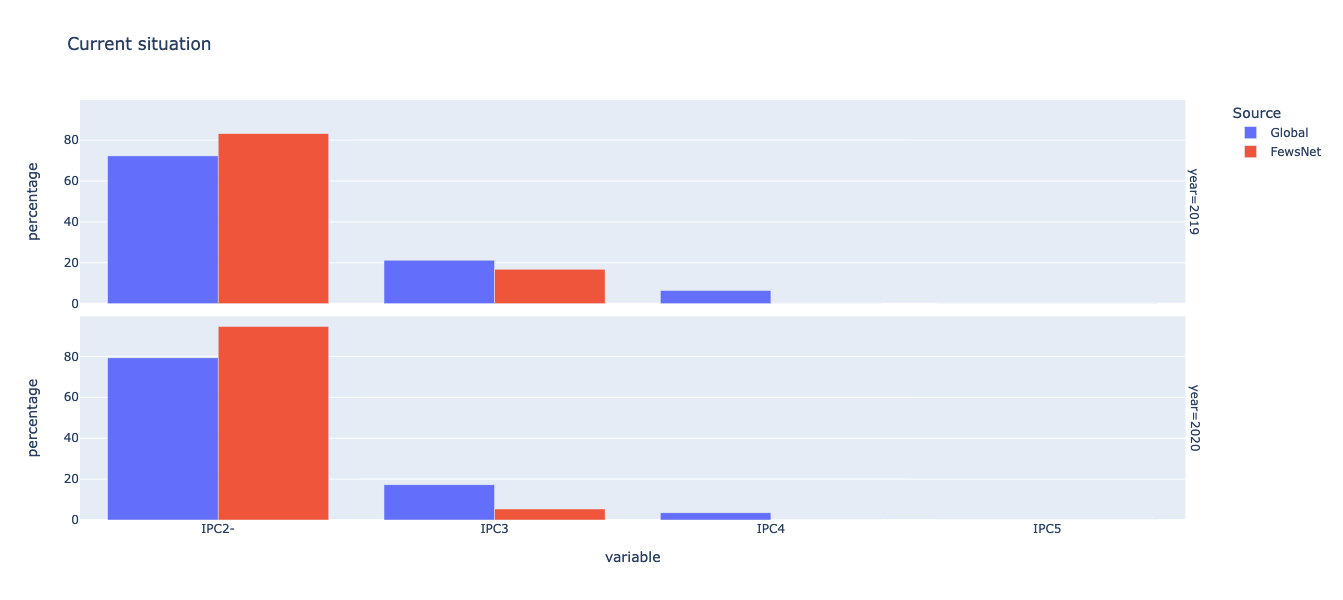

In [37]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Current situation") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_CS_2m","perc_CS_3","perc_CS_4","perc_CS_5"])

fig.show()

In [38]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_ML1_2m','perc_ML1_3',"perc_ML1_4","perc_ML1_5"])

In [39]:
df_combm["year"]=df_combm.date.dt.year

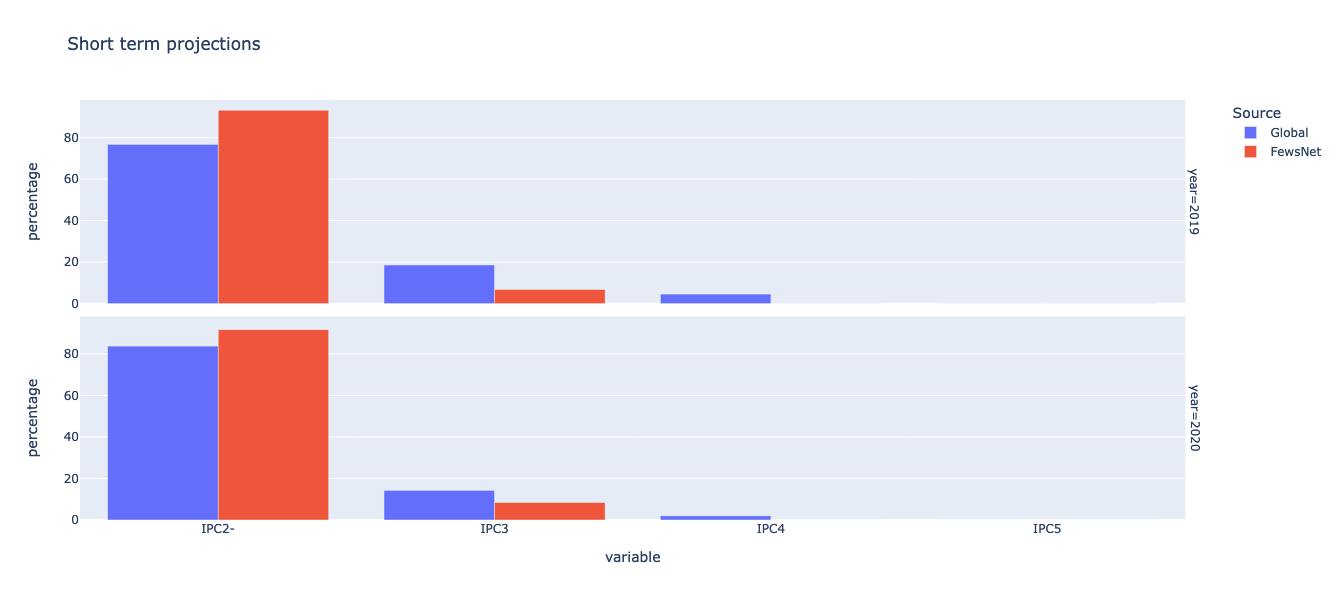

In [40]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Short term projections") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_ML1_2m","perc_ML1_3","perc_ML1_4","perc_ML1_5"])
fig.show()

In [41]:
df_combm=df_comb.melt(id_vars=["Source","date"],value_name="percentage",value_vars=['perc_ML2_2m','perc_ML2_3',"perc_ML2_4","perc_ML2_5"])

In [42]:
df_combm["year"]=df_combm.date.dt.year

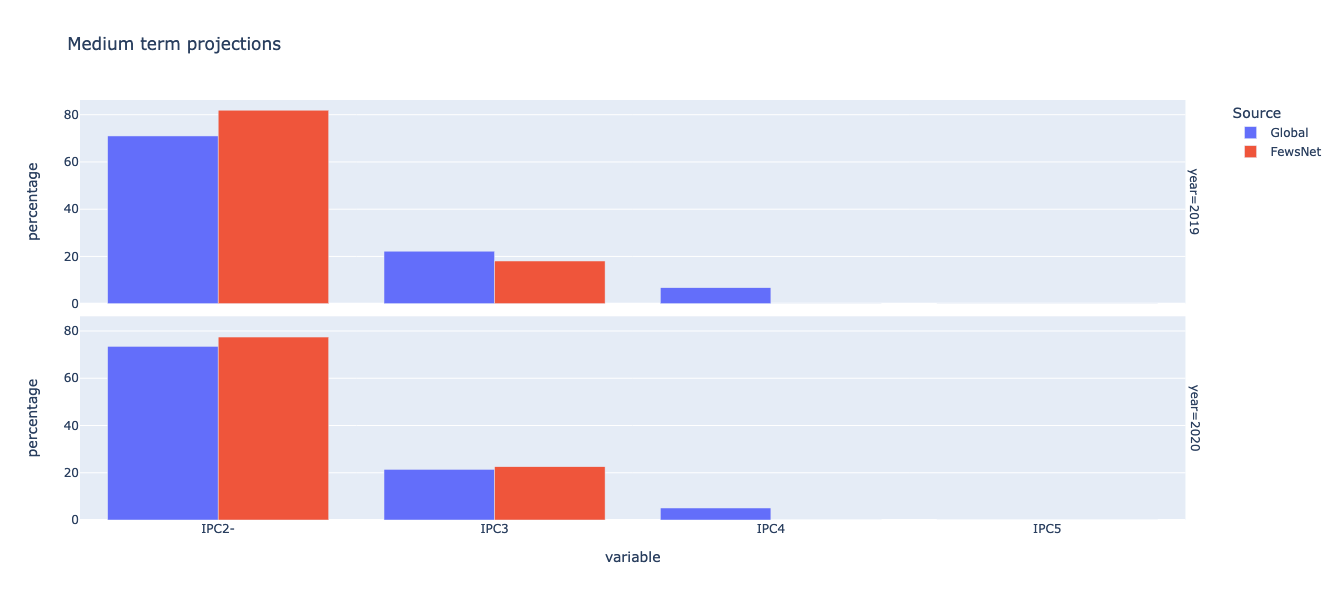

In [43]:
fig=px.bar(df_combm,x="variable",y="percentage",color="Source",facet_row="year",barmode="group",height=600,width=800,title="Medium term projections") #,facet_row="year"
fig.update_xaxes(ticktext=["IPC2-","IPC3","IPC4","IPC5"],tickvals=["perc_ML2_2m","perc_ML2_3","perc_ML2_4","perc_ML2_5"])
fig.show()

In [44]:
g_adm1=df_gadm.ADMIN1.unique()

In [45]:
df_fadms=df_fadm[df_fadm.date.isin(["2019-10","2020-06"])]

In [46]:
df_fadms=df_fadms.rename(columns={"ADM1_EN":"ADMIN1"})
df_fadms=df_fadms[df_fadms.ADMIN1.isin(g_adm1)]

df_fadms["Source"]="FewsNet"
df_gadm["Source"]="Global"

In [47]:
df_adm1c=pd.concat([df_gadm,df_fadms])

In [48]:
df_adm1cm=df_adm1c.melt(id_vars=["Source","date","ADMIN1"],value_name="percentage",value_vars=['perc_CS_2m','perc_CS_3',"perc_CS_4","perc_CS_5"])
df_adm1cm["year"]=df_adm1cm.date.dt.year

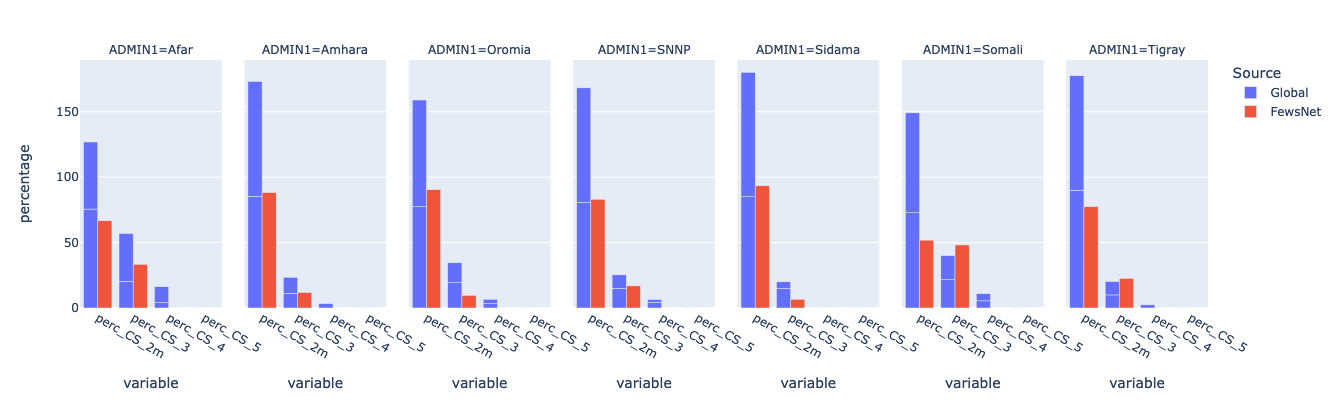

In [49]:
#Sidama is a new admin1 region in Ethiopia that wasn't included in the 06-2020 FewsNet analysis
px.bar(df_adm1cm[df_adm1cm.year==2020],x="variable",y="percentage",color="Source",facet_col="ADMIN1",barmode="group",height=400,width=1300) #,facet_row="year"

### NOT WORKING: Actual value (CS) versus forecasted values (ML1 and ML2)
**NOTE**: the code from here is not working. Too many structures changed in the files, and I believe the code below is not 
correctly doing what it is supposed to do. So leaving it here for the idea, but should be revisited (and prob best just start from scratch again) if actually being used!!
Only being done for FewsNet.  
For global IPC we have two timestamps of data till today, where none of the dates overlap. Thus, we cannot do an analysis on accuracy

In [50]:
#set the forecasted ML1 and ML2 values for the connected date
#now assumed ML1 is always forecasted for the next date in the df. This can be too simplified, in 'old stuff' is a start to do this more correctly
#(optimally the dates for which forecasts were produced would already be included in the df from the start)
shift_cols_ML1=["date"] + [f"ML1_{i}" for i in range(1,6)]+[f"perc_ML1_{i}" for i in range(1,6)]+["ML1_3p","perc_ML1_3p"]
shift_cols_ML2=["date"] + [f"ML2_{i}" for i in range(1,6)]+[f"perc_ML2_{i}" for i in range(1,6)]+["ML2_3p","perc_ML2_3p"]
df_fnat[[f"{c}_next" for c in shift_cols_ML1]]=df_fnat[shift_cols_ML1].shift(1)
df_fnat[[f"{c}_next2" for c in shift_cols_ML2]]=df_fnat[shift_cols_ML2].shift(2)
df_fadm[[f"{c}_next" for c in shift_cols_ML1]]=df_fadm.groupby("ADMIN1")[shift_cols_ML1].shift(1)
df_fadm[[f"{c}_next2" for c in shift_cols_ML2]]=df_fadm.groupby("ADMIN1")[shift_cols_ML2].shift(2)

#set to nan if difference in dates is larger than 130/250, i.e. forecast was not for next date in df
#dont include "date" in shift_cols_ML1
for i in shift_cols_ML1[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next) <= timedelta(130), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next) <= timedelta(130), np.nan)
for i in shift_cols_ML2[1:]:
    df_fnat[i] = df_fnat[i].where((df_fnat.date - df_fnat.date_next2) <= timedelta(250), np.nan)
    df_fadm[i] = df_fadm[i].where((df_fadm.date - df_fadm.date_next2) <= timedelta(250), np.nan)

In [51]:
df_fadmt=pd.read_csv(fnocha_adm2_path,index_col=0)

In [52]:
fn_ocha_adm2c="ADM2_EN"
fn_ocha_adm1c="ADM1_EN"

In [53]:
#add forecasted values to date they were forecasted for
for a in df_fadmt[fn_ocha_adm1c].unique():
    for b in df_fadmt[fn_ocha_adm2c].unique():
        df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),f"ML1_next"]=df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),"ML1"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),f"ML2_next2"]=df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),"ML2"].shift(2).to_numpy()
        df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),f"date_next"]=df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),"date"].shift(1).to_numpy()
        df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),f"date_next2"]=df_fadmt.loc[(df_fadmt[fn_ocha_adm1c]==a) & (df_fadmt[fn_ocha_adm2c]==b),"date"].shift(2).to_numpy()

In [54]:
df_fadmt["CS_3p"]=np.where(df_fadmt.CS>=3,1,0)
df_fadmt["ML1_next_3p"]=np.where(df_fadmt.ML1_next>=3,1,0)
df_fadmt["ML2_next2_3p"]=np.where(df_fadmt.ML2_next2>=3,1,0)

In [55]:
df_fadmts=df_fadmt.dropna()

In [56]:
print("Accuracy of ML1 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML1_next))

Accuracy of ML1 forecasts: 0.5825974025974026


In [57]:
print("Accuracy of ML2 forecasts:",accuracy_score(df_fadmts.CS,df_fadmts.ML2_next2))

Accuracy of ML2 forecasts: 0.6041558441558441


In [58]:
print("Accuracy of ML1 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML1_next_3p))

Accuracy of ML1 forecasts for IPC3+: 0.7306493506493507


In [59]:
print("Accuracy of ML2 forecasts for IPC3+:",accuracy_score(df_fadmts.CS_3p,df_fadmts.ML2_next2_3p))

Accuracy of ML2 forecasts for IPC3+: 0.7625974025974026


In [60]:
df_fadmt["CSminML1"]=df_fadmt["CS"]-df_fadmt["ML1_next"]

In [61]:
#can be seen that about equally divided whether ML1 is over or underpredicting CS
df_fadmt.value_counts("CSminML1").sort_index()

CSminML1
-3.0       9
-2.0     143
-1.0     633
 0.0    2306
 1.0     736
 2.0     118
 3.0       1
dtype: int64

In [62]:
#can be seen that about equally divided whether ML1 is over or underpredicting CS
df_fadmt.value_counts("CSminML1").sort_index()

CSminML1
-3.0       9
-2.0     143
-1.0     633
 0.0    2306
 1.0     736
 2.0     118
 3.0       1
dtype: int64

In [63]:
df_fadmt["CSminML2"]=df_fadmt["CS"]-df_fadmt["ML2_next2"]

In [64]:
df_fadmt.value_counts("CSminML2").sort_index()

CSminML2
-3.0       4
-2.0     123
-1.0     606
 0.0    2328
 1.0     612
 2.0     167
 3.0      13
dtype: int64

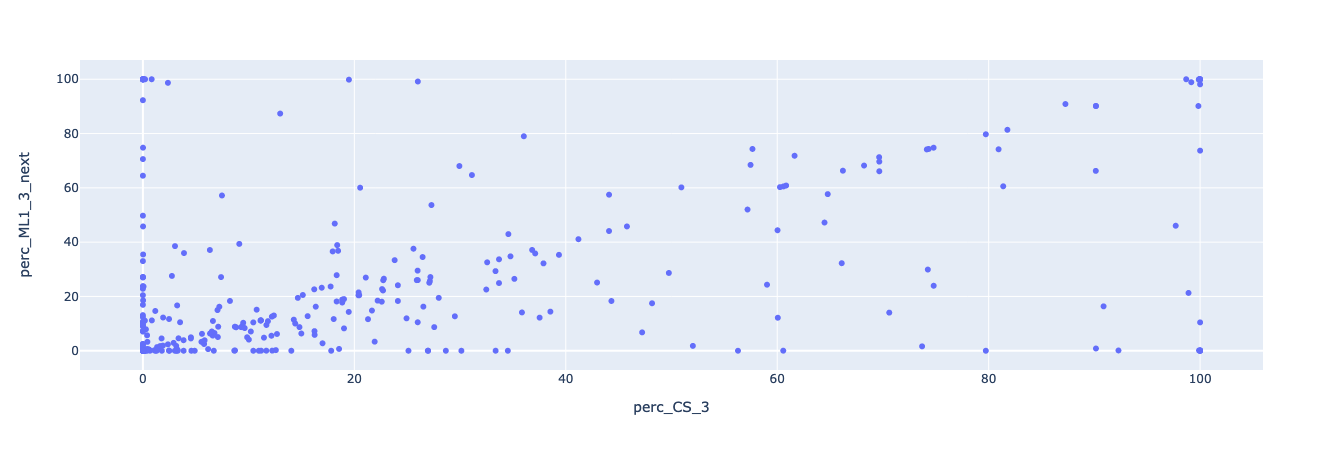

In [65]:
px.scatter(df_fadm,x="perc_CS_3",y="perc_ML1_3_next",width=500,height=450)

In [66]:
def plot_preds(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p_next'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p_next2'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"{region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("Date")
        ax.set_ylabel("Percentage of population")
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)

In [67]:
plot_preds(df_fnat)

KeyError: 'ADM1_EN'

In [ ]:
plot_preds(df_fadm)

In [ ]:
def plot_preds_nodelay(df,adm1c="ADM1_EN"):
    color_map = {1:'#C9E1C5', 2:'#F2E65D', 3:'#DD8236', 4:'#BD3430', 5:'#551010', 99: '#CCCCCC'}
    
    width = 75
    count = 1
    fig, ax = plt.subplots(figsize=(20,30))
  
    for region in df[adm1c].unique():
        ax = plt.subplot(6,2,count)
        data = df.loc[df[adm1c]==region]
        plt.plot(data['date'], data['perc_CS_3p'], label='CS',
                         alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
        plt.plot(data['date'], data['perc_ML1_3p'], color='#388c50',
                         label='ML1', linestyle=':', linewidth=2)
        plt.plot(data['date'], data['perc_ML2_3p'], color='#c24e2d',
                         label='ML2', linestyle='-.', linewidth=2)
        plt.title(f"NO DELAY! {region} IPC 3+")
        ax.legend(bbox_to_anchor=(1.04, 1),frameon=False,title="Legend")

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        ax.set_xticks(data.date.values,minor=True)
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        count+=1
    fig.tight_layout(pad=3.0)
    

In [ ]:
plot_preds_nodelay(df_fnat)

In [ ]:
plot_preds_nodelay(df_fadm)

In [ ]:
df_fnat[f"ML1_i"]=(df_fnat["perc_ML1_3p"]-df_fnat["perc_CS_3p"])
df_fnat[f"ML2_i"]=(df_fnat["perc_ML2_3p"]-df_fnat["perc_CS_3p"])

In [ ]:
plt.figure(figsize=(15, 8))
plt.ticklabel_format(style='plain', axis='y')
plt.plot(df_fnat['date'], df_fnat['ML1_i'], label='ML1 wrt CS',
                 alpha=0.75, color='#E6B655', linestyle='-', linewidth=4)
plt.plot(df_fnat['date'], df_fnat['ML2_i'], label='ML2 wrt CS',
                 alpha=0.75, color='#CA7E8D', linestyle='-', linewidth=4)
plt.ylabel("Percentual change pop. in IPC 3+")
plt.title("Projected percentual change in population in IPC3+")
plt.legend()